In [2]:
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score

In [3]:
classifier_df = pd.read_csv('/Users/dianakazarian/Documents/politicsclassifier/data/classifierdata_processed.csv')

# Assess Class Imbalance

In [4]:
classifier_df['class'].value_counts()

0    7826
1    4010
Name: class, dtype: int64

# Initialize Model (SVM)

In [6]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(classifier_df['text'], classifier_df['class'], test_size=0.2)

# Create a pipeline with TF-IDF vectorizer and SVM classifier
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('svm', SVC(kernel='linear', probability=True))  # Enable probability estimates for AUC calculation
])

# Grid Search for Hyperparameter Tuning

In [8]:
# Define parameter grid for grid search
param_grid = {
    'tfidf__max_features': [1000, 2000, 3000],
    'tfidf__ngram_range': [(1, 1), (1, 2)],
    'svm__C': [0.1, 1, 10],
    'svm__class_weight': [None, 'balanced']
}

# Perform grid search with 5-fold cross-validation
grid_search = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Print best parameters
print("Best Parameters:", grid_search.best_params_)

Best Parameters: {'svm__C': 1, 'svm__class_weight': 'balanced', 'tfidf__max_features': 3000, 'tfidf__ngram_range': (1, 1)}


# Fit Model, Calculate Metrics

In [11]:
# Predictions
y_pred = grid_search.predict(X_test)

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# AUC Score
y_pred_proba = grid_search.predict_proba(X_test)
auc_score = roc_auc_score(y_test, y_pred_proba[:, 1])  # Use probabilities of positive class
print("AUC Score:", auc_score)


Accuracy: 0.8842905405405406
AUC Score: 0.9512515943877551


# Other Metrics (Class Imbalance)

In [13]:
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report, confusion_matrix

# Precision
precision = precision_score(y_test, y_pred, average='weighted')
print("Precision:", precision)

# Recall
recall = recall_score(y_test, y_pred, average='weighted')
print("Recall:", recall)

# F1 Score
f1 = f1_score(y_test, y_pred, average='weighted')
print("F1 Score:", f1)
print("\n")

# Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("\n")

# Confusion Matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Precision: 0.8879553466509988
Recall: 0.8842905405405406
F1 Score: 0.8853964383926102


Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.89      0.91      1584
           1       0.80      0.87      0.83       784

    accuracy                           0.88      2368
   macro avg       0.87      0.88      0.87      2368
weighted avg       0.89      0.88      0.89      2368



Confusion Matrix:
[[1414  170]
 [ 104  680]]


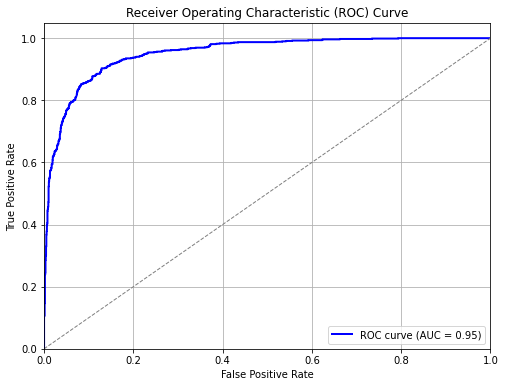

In [14]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

# Compute ROC curve and ROC area for each class
fpr, tpr, _ = roc_curve(y_test, y_pred_proba[:, 1])  # Use probabilities of positive class

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % auc_score)
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

In [15]:
from joblib import dump

# Save the trained model
model_filename = 'svm_model.joblib'
dump(grid_search.best_estimator_, model_filename)

['svm_model.joblib']